In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()
print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...


In [2]:
def initspark():
    spark = SparkSession.builder.appName('mlonspark')\
        .config('spark.executor.instances', '3')\
        .getOrCreate()
    print('pyspark ready ...')
    return spark

In [3]:
from pyspark.ml.recommendation import ALS
def initalg(val):
    return ALS()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("stdCountPos")\
    .setRegParam(val)\
    .setImplicitPrefs(True)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot(res):
    x = []
    yTrain = []
    yTest = []
    for v in res:
        x.append(v[0])
        yTrain.append(v[1])
        yTest.append(v[2])

    plt.figure(figsize=(8,4))
    plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
    plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
    plt.legend(loc="upper left", fontsize=15)
    plt.ylabel("RMSE", fontsize=18)

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        spark = initspark();
        train = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-train.parquet")
        test = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-test.parquet")
        
        evaluator = RegressionEvaluator()\
            .setMetricName("rmse")\
            .setLabelCol("stdCountPos")\
            .setPredictionCol("prediction")
        
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        
        
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        
        
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        
        
        res.append([i, trainRmse, testRmse])
        plot(res)
        spark.stop()
    return res

pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
[[0.0, 1.291583454385028, 1.3063909070037316], [0.2, 1.3056072581253877, 1.315652818486499], [0.4, 1.3204059022191532, 1.3271891727925358], [0.6000000000000001, 1.3344046597558383, 1.3389322353369486], [0.8, 1.3461020773746428, 1.3492668178324938], [1.0, 1.355712899683344, 1.358052441343366], [1.2000000000000002, 1.362851801941391, 1.3647466671431963], [1.4000000000000001, 1.3675282203107921, 1.3692212021440535], [1.6, 1.3704521087674248, 1.372069720901104], [1.8, 1.3714668992146186, 1.3730685878112823]]


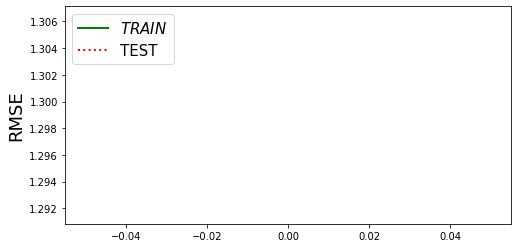

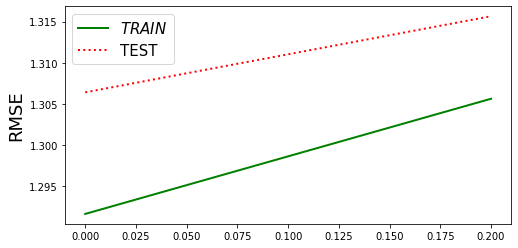

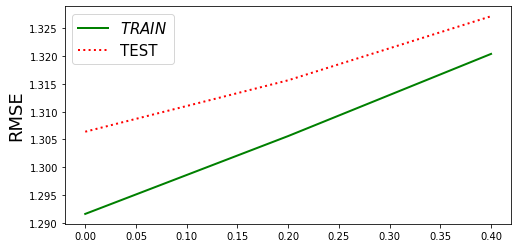

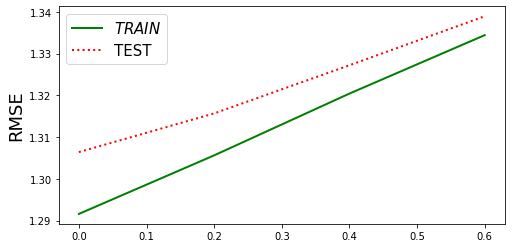

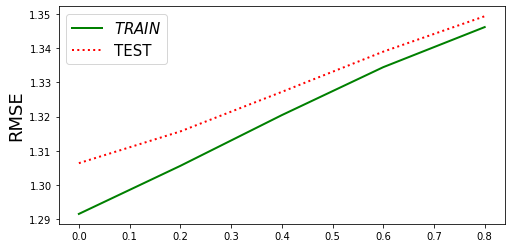

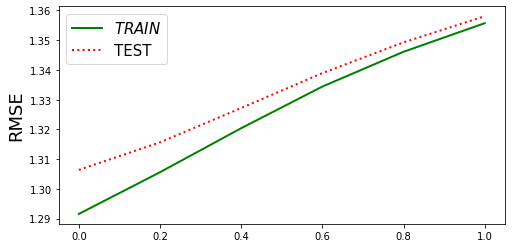

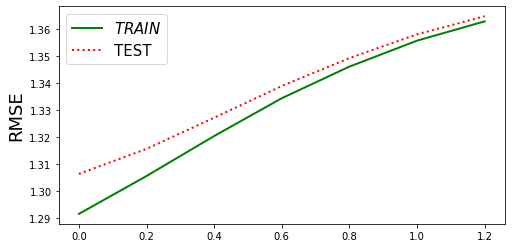

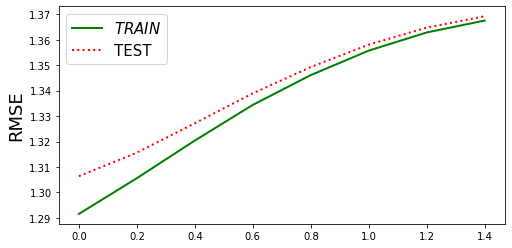

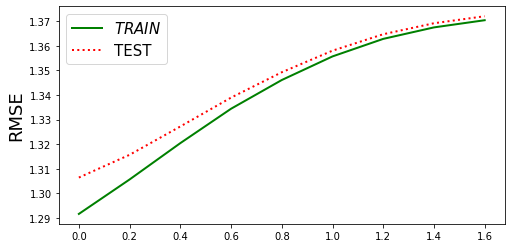

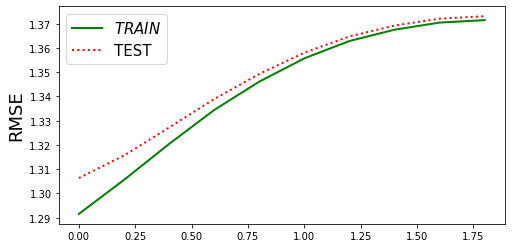

In [6]:
%matplotlib inline

import numpy as np
rng = np.arange(0.0, 2.0, 0.2).tolist()
res = runtest(rng)
print(res)

In [7]:
x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

print(yTest)

[1.3063909070037316, 1.315652818486499, 1.3271891727925358, 1.3389322353369486, 1.3492668178324938, 1.358052441343366, 1.3647466671431963, 1.3692212021440535, 1.372069720901104, 1.3730685878112823]


Text(0, 0.5, 'RMSE')

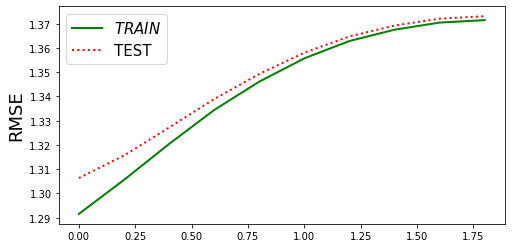

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)